# Group 20 — Clustering

This notebook performs exploratory data analysis on customer and flights databases, covering data inspection, quality assessment, and preprocessing.

## Table of Contents
- [Data Import](#data-import)
- [Data Preprocessing](#preprocessing)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Functions

In [2]:
def preprocess_flights(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the FlightsDB:
    - Convert YearMonthDate to datetime
    - Round down NumFlights and NumFlightsWithCompanions
    - Set DistanceKM = 0 where NumFlights == 0
    - Drop DollarCostPointsRedeemed
    - Add log-transformed versions of skewed variables
    - Create PointsUtilizationRatio = PointsRedeemed / PointsAccumulated
    """
    df = flights_df.copy()

    # 1. YearMonthDate -> datetime
    if 'YearMonthDate' in df.columns:
        df['YearMonthDate'] = pd.to_datetime(df['YearMonthDate'])

    # 2. Round down flight counts and cast to int
    for col in ['NumFlights', 'NumFlightsWithCompanions']:
        if col in df.columns:
            df[col] = np.floor(df[col]).astype(int)

    # 3. Fix logical inconsistency: DistanceKM must be 0 if NumFlights == 0
    if {'NumFlights', 'DistanceKM'}.issubset(df.columns):
        df.loc[df['NumFlights'] == 0, 'DistanceKM'] = 0

    # 4. Drop perfectly correlated variable
    if 'DollarCostPointsRedeemed' in df.columns:
        df = df.drop(columns=['DollarCostPointsRedeemed'])

    # 5. Log transforms for skewed numeric variables
    log_cols = ['DistanceKM', 'PointsAccumulated', 'PointsRedeemed']
    for col in log_cols:
        if col in df.columns:
            df[f'{col}_log'] = np.log1p(df[col])

    # 6. Points utilisation ratio
    if {'PointsRedeemed', 'PointsAccumulated'}.issubset(df.columns):
        denom = df['PointsAccumulated'].replace({0: np.nan})
        df['PointsUtilizationRatio'] = df['PointsRedeemed'] / denom

    return df


def preprocess_customers(customer_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the CustomerDB:
    - Create cancellation flag from CancellationDate
    - Group-median imputation (by LoyaltyStatus) for Income and Customer Lifetime Value
    - Log transform Customer Lifetime Value
    - Create Location feature (region) from Province or State (placeholder mapping)
    - Create CustomerValueScore composite feature
    """
    df = customer_df.copy()

    # 1. Cancellation flag
    if 'CancellationDate' in df.columns:
        df['CancelledFlag'] = df['CancellationDate'].notna().astype(int)

    # 2. Group-median imputation by LoyaltyStatus
    group_col = 'LoyaltyStatus'
    cols_to_impute = ['Income', 'Customer Lifetime Value']
    for col in cols_to_impute:
        if col in df.columns and group_col in df.columns:
            df[col] = df.groupby(group_col)[col].transform(
                lambda x: x.fillna(x.median())
            )

    # 3. Log transform Customer Lifetime Value (for variance stabilisation)
    if 'Customer Lifetime Value' in df.columns:
        df['CustomerLifetimeValue_log'] = np.log1p(df['Customer Lifetime Value'])

    # 4. Location feature (region mapping)
    if 'Province or State' in df.columns:
        region_map = {
            'Ontario': 'Central',
            'Quebec': 'Quebec',
            'British Columbia': 'West',
            'Alberta': 'West',
            'Saskatchewan': 'West',
            'Manitoba': 'West',
            'New Brunswick': 'Atlantic',
            'Nova Scotia': 'Atlantic',
            'Prince Edward Island': 'Atlantic',
            'Newfoundland and Labrador': 'Atlantic',
            'Yukon': 'North',
            'Northwest Territories': 'North',
            'Nunavut': 'North',
        }

        df['Location'] = df['Province or State'].map(region_map).fillna('Other')

    # 5. Customer Value Score (simple composite of CLV and Income)
    clv_col = 'CustomerLifetimeValue_log'
    if clv_col in df.columns:
        clv_scaled = (df[clv_col] - df[clv_col].mean()) / df[clv_col].std(ddof=0)

        if 'Income' in df.columns:
            income_log = np.log1p(df['Income'].clip(lower=0))
            income_scaled = (income_log - income_log.mean()) / income_log.std(ddof=0)
            # Heavier weight on CLV, lighter on Income
            df['CustomerValueScore'] = 0.7 * clv_scaled + 0.3 * income_scaled
        else:
            df['CustomerValueScore'] = clv_scaled

    return df

def build_customer_flight_features(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate monthly flight records into customer-level features:
    - TotalFlights, TotalDistanceKM, TotalPointsAccumulated, TotalPointsRedeemed
    - MeanPointsUtilization
    - AverageFlightDistance
    - FlightActivityScore (based on z-scores of flights and distance)
    """
    id_col = 'Loyalty#'
    df = flights_df.copy()

    agg = (
        df
        .groupby(id_col)
        .agg(
            TotalFlights=('NumFlights', 'sum'),
            TotalDistanceKM=('DistanceKM', 'sum'),
            TotalPointsAccumulated=('PointsAccumulated', 'sum'),
            TotalPointsRedeemed=('PointsRedeemed', 'sum'),
            MeanPointsUtilization=('PointsUtilizationRatio', 'mean')
        )
        .reset_index()
    )

    # Average flight distance = total distance / total flights
    agg['AverageFlightDistance'] = agg['TotalDistanceKM'] / agg['TotalFlights'].replace({0: np.nan})

    # FlightActivityScore: combines total flights and distance (z-scores)
    for col in ['TotalFlights', 'TotalDistanceKM']:
        mean = agg[col].mean()
        std = agg[col].std(ddof=0)
        if std == 0:
            agg[f'{col}_z'] = 0
        else:
            agg[f'{col}_z'] = (agg[col] - mean) / std

    agg['FlightActivityScore'] = agg['TotalFlights_z'] + agg['TotalDistanceKM_z']

    return agg

def winsorize_dataframe(df, columns, limits=(0.01, 0.01)):
    """
    Apply winsorization to each column in `columns`.
    limits=(lower_pct, upper_pct) means: cap values at the 1st and 99th percentile.

    Returns the winsorized copy of df.
    """
    df = df.copy()
    for col in columns:
        if col in df.columns:
            # winsorize returns masked arrays -> convert to normal array
            df[col] = winsorize(df[col], limits=limits).data
    return df

# <a id="data-import"></a> Data Import

In [3]:
# Load the data
customer_db = pd.read_csv("data/DM_AIAI_CustomerDB.csv", index_col=0 )
flights_db = pd.read_csv("data/DM_AIAI_FlightsDB.csv")

# <a id="preprocessing"></a> Data Preprocessing

In this section we apply the preprocessing and feature engineering steps
described in the report:

- Fix data types and logical inconsistencies in **FlightsDB**
- Handle missing values and transform skewed variables in **CustomerDB**
- Create new features: log-transformed variables, points utilisation,
  cancellation flag, customer value score, flight activity score, and
  average flight distance.



In [4]:
# Remove duplicates in customer database
initial_rows = customer_db.shape[0]
duplicated_loyalty_ids = customer_db[customer_db['Loyalty#'].duplicated()]['Loyalty#'].unique()
customer_db = customer_db.drop_duplicates(subset=['Loyalty#'])
dropped_rows = initial_rows - customer_db.shape[0]
dropped_percentage = (dropped_rows / initial_rows) * 100

print(f"Dropped {dropped_rows} duplicate customers ({dropped_percentage:.2f}%).")
# Note: We do not filter flights_db here because the inner join later will automatically exclude flights from dropped customers.

Dropped 164 duplicate customers (0.97%).


In [5]:
# Run preprocessing for each table
customer_preprocessed = preprocess_customers(customer_db)
flights_preprocessed = preprocess_flights(flights_db)

# Build customer-level flight features
customer_flight_features = build_customer_flight_features(flights_preprocessed)

# Merge into a single modelling dataset (one row per customer)
id_col = 'Loyalty#'
model_df = (
    customer_preprocessed
    .merge(customer_flight_features, on=id_col, how='inner')
)

print("Customer-preprocessed shape:", customer_preprocessed.shape)
print("Flights-preprocessed shape:", flights_preprocessed.shape)
print("Model dataset shape:", model_df.shape)

model_df.head()

Customer-preprocessed shape: (16757, 24)
Flights-preprocessed shape: (608436, 13)
Model dataset shape: (16737, 33)


,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,CustomerValueScore,TotalFlights,TotalDistanceKM,TotalPointsAccumulated,TotalPointsRedeemed,MeanPointsUtilization,AverageFlightDistance,TotalFlights_z,TotalDistanceKM_z,FlightActivityScore
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,...,-0.326926,184,476229.8,50699.39,13517.9,0.267219,2588.205435,0.558399,1.228108,1.786507
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,...,-1.043114,275,389938.9,42672.54,22457.8,1.559035,1417.959636,1.690882,0.693025,2.383908
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,...,-1.043075,116,208146.7,23832.41,5479.6,0.947354,1794.368103,-0.287852,-0.434252,-0.722105
3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,...,-1.043075,191,372178.3,38595.63,16331.5,1.171049,1948.577487,0.645513,0.582893,1.228406
4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,...,-0.304550,167,344036.5,36916.56,0.0,0.000000,2060.098802,0.346836,0.408389,0.755225


In [6]:
# Apply winsorization to the merged dataset
flight_outlier_cols = [
    'TotalFlights',
    'TotalDistanceKM',
    'TotalPointsAccumulated',
    'TotalPointsRedeemed',
    'AverageFlightDistance'
]

customer_outlier_cols = [
    'Income',
    'Customer Lifetime Value',
    'CustomerLifetimeValue_log'
]

# Winsorize both sets of columns on the model_df directly
model_df = winsorize_dataframe(
    model_df,
    columns=flight_outlier_cols + customer_outlier_cols,
    limits=(0.01, 0.01)    # winsorize at 1% and 99%
)

print("Winsorization applied to model_df.")

Winsorization applied to model_df.


In [7]:
# Check for remaining missing values
model_df.isna().sum().sort_values(ascending=False).head(15)


CancellationDate         14469
AverageFlightDistance     1501
MeanPointsUtilization     1497
Loyalty#                     0
First Name                   0
Province or State            0
Last Name                    0
Customer Name                0
Country                      0
Postal code                  0
Gender                       0
Education                    0
Location Code                0
Income                       0
City                         0
dtype: int64

In [8]:
# Drop CancellationDate (flag already exists)
model_df = model_df.drop(columns=['CancellationDate'], errors='ignore')

# Fill average distance for zero-flight customers
model_df['AverageFlightDistance'] = model_df['AverageFlightDistance'].fillna(0)

# Fill points utilization for customers with no point activity
model_df['MeanPointsUtilization'] = model_df['MeanPointsUtilization'].fillna(0)

# Fill ALL flight-related NaNs with 0
flight_cols = [
    'TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated',
    'TotalPointsRedeemed', 'MeanPointsUtilization', 'AverageFlightDistance',
    'TotalFlights_z', 'TotalDistanceKM_z', 'FlightActivityScore'
]

for col in flight_cols:
    model_df[col] = model_df[col].fillna(0)


In [9]:
# Numerical features for clustering
numeric_features = [
    'Income',
    'CustomerLifetimeValue_log',
    'CustomerValueScore',
    
    'TotalFlights',
    'TotalDistanceKM',
    'AverageFlightDistance',
    'TotalPointsAccumulated',
    'TotalPointsRedeemed',
    'MeanPointsUtilization',
    'FlightActivityScore',

    'CancelledFlag'
]

# Categorical features to encode
categorical_features = [
    'EnrollmentType',  # Bronze, Silver, Gold ...
    'Location'         # Region/Province after mapping
]


In [10]:
df_selected = model_df[numeric_features + categorical_features].copy()
df_selected.head()


,Income,CustomerLifetimeValue_log,CustomerValueScore,TotalFlights,TotalDistanceKM,AverageFlightDistance,TotalPointsAccumulated,TotalPointsRedeemed,MeanPointsUtilization,FlightActivityScore,CancelledFlag,EnrollmentType,Location
0,70146.0,8.253264,-0.326926,184,476229.8,2588.205435,50699.39,13517.9,0.267219,1.786507,0,Standard,Central
1,0.0,8.253386,-1.043114,275,389938.9,1417.959636,42672.54,22457.8,1.559035,2.383908,0,Standard,West
2,0.0,8.253423,-1.043075,116,208146.7,1794.368103,23832.41,5479.6,0.947354,-0.722105,1,Standard,West
3,0.0,8.253423,-1.043075,191,372178.3,1948.577487,38595.63,16331.5,1.171049,1.228406,0,Standard,Central
4,97832.0,8.254214,-0.304550,167,344036.5,2060.098802,36916.56,0.0,0.000000,0.755225,0,2021 Promotion,Quebec


In [11]:
df_encoded = pd.get_dummies(df_selected, columns=categorical_features, drop_first=True)
df_encoded.head()


,Income,CustomerLifetimeValue_log,CustomerValueScore,TotalFlights,TotalDistanceKM,AverageFlightDistance,TotalPointsAccumulated,TotalPointsRedeemed,MeanPointsUtilization,FlightActivityScore,CancelledFlag,EnrollmentType_Standard,Location_Central,Location_North,Location_Other,Location_Quebec,Location_West
0,70146.0,8.253264,-0.326926,184,476229.8,2588.205435,50699.39,13517.9,0.267219,1.786507,0,True,True,False,False,False,False
1,0.0,8.253386,-1.043114,275,389938.9,1417.959636,42672.54,22457.8,1.559035,2.383908,0,True,False,False,False,False,True
2,0.0,8.253423,-1.043075,116,208146.7,1794.368103,23832.41,5479.6,0.947354,-0.722105,1,True,False,False,False,False,True
3,0.0,8.253423,-1.043075,191,372178.3,1948.577487,38595.63,16331.5,1.171049,1.228406,0,True,True,False,False,False,False
4,97832.0,8.254214,-0.304550,167,344036.5,2060.098802,36916.56,0.0,0.000000,0.755225,0,False,False,False,False,True,False


In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

X_scaled[:5]


array([[ 1.06797991, -0.7633305 , -0.42197537,  0.57256306,  1.25418423,
         0.58813489,  1.33636497,  0.58797181, -0.25055795,  0.91135102,
        -0.39591528,  0.27073497,  1.44815409, -0.08133723, -0.1251251 ,
        -0.49332518, -0.7920362 ],
       [-1.24361464, -0.76314074, -1.34590253,  1.72154486,  0.71056388,
        -0.43811577,  0.84768272,  1.63438492,  0.61567329,  1.21610321,
        -0.39591528,  0.27073497, -0.69053425, -0.08133723, -0.1251251 ,
        -0.49332518,  1.26256855],
       [-1.24361464, -0.76308422, -1.34585202, -0.28601674, -0.43470103,
        -0.10802321, -0.29932228, -0.35290924,  0.20550845, -0.36836738,
         2.52579287,  0.27073497, -0.69053425, -0.08133723, -0.1251251 ,
        -0.49332518,  1.26256855],
       [-1.24361464, -0.76308422, -1.34585202,  0.66094628,  0.59867463,
         0.02721119,  0.59947657,  0.917303  ,  0.35550812,  0.62664722,
        -0.39591528,  0.27073497,  1.44815409, -0.08133723, -0.1251251 ,
        -0.49332518

## Variable selection: Redundancy VS Relevancy

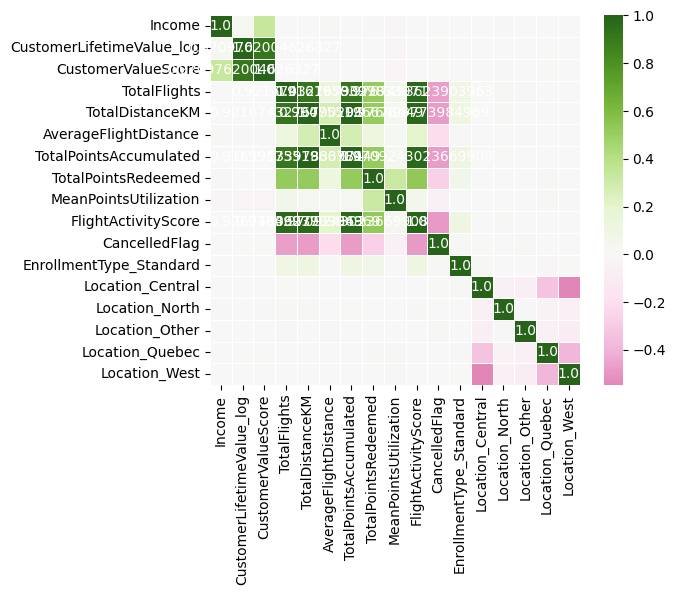

In [13]:
df_scaled = pd.DataFrame(X_scaled, columns=df_encoded.columns)
corr = df_scaled.corr(method="pearson")

sns.heatmap(
    corr,
    center = 0,
    cmap='PiYG',
    annot=np.where(np.absolute(corr) >= 0.8, corr.values, np.full(corr.values.shape, "")),
    fmt='s',
    square=True,
    linewidths=.5,
)
plt.show()

In [14]:
# Features to drop due to high correlation (>0.8)
features_to_drop = {
    'AverageFlightDistance',    
    'TotalPointsRedeemed',         
    'MeanPointsUtilization',  
    'Location_Central',   
    'Location_North',   
    'Location_Other',   
    'Location_Quebec',   
    'Location_West',   
    }   

df_encoded_before_corr_drop = df_encoded.copy()

df_encoded = df_encoded.drop(columns=features_to_drop, errors='ignore')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

print("Features dropped:", features_to_drop)
print("\nShape of the scaled data after dropping features:", X_scaled.shape)
print("\nRemaining features:")
print(df_encoded.columns.tolist())

Features dropped: {'AverageFlightDistance', 'Location_Central', 'TotalPointsRedeemed', 'Location_Other', 'Location_Quebec', 'MeanPointsUtilization', 'Location_West', 'Location_North'}

Shape of the scaled data after dropping features: (16737, 9)

Remaining features:
['Income', 'CustomerLifetimeValue_log', 'CustomerValueScore', 'TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated', 'FlightActivityScore', 'CancelledFlag', 'EnrollmentType_Standard']


# DBSCAN 


To identify anomalous customer behavior, the DBSCAN algorithm was applied to the scaled feature space. In this project, DBSCAN is used exclusively for outlier detection, not for final customer segmentation.

In [15]:
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=1)
dbscan_labels = dbscan.fit_predict(X_scaled)

outlier_count = Counter(dbscan_labels)
print(f"DBSCAN results: {outlier_count}")
print(f"Outliers detected: {outlier_count.get(-1, 0)}")
print(f"Core customers: {outlier_count.get(0, 0)}")

DBSCAN results: Counter({np.int64(0): 13460, np.int64(1): 2134, np.int64(2): 1009, np.int64(3): 128, np.int64(-1): 6})
Outliers detected: 6
Core customers: 13460


The algorithm identified multiple dense regions in the data, reflecting local behavioral patterns across customers. A small fraction of observations was classified as noise.

In [16]:
core_mask = (dbscan_labels != -1)

X_scaled = X_scaled[core_mask]

print(f"Core customers kept: {len(X_scaled):,}")


Core customers kept: 16,731


DBSCAN successfully identified a small proportion of anomalous customers (~5%), while preserving the vast majority of the dataset for subsequent analysis. This confirms that most customers exhibit consistent behavior, and that outliers can be safely removed to improve the robustness of downstream clustering and modeling tasks.

## Clustering

In [17]:
inertias = []
silhouettes = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        random_state=42,
        n_init=20
    )
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)

    print(f"For n_clusters = {k}, the average silhouette_score is : {sil}")


For n_clusters = 2, the average silhouette_score is : 0.3842582947269548
For n_clusters = 3, the average silhouette_score is : 0.24781256704488094
For n_clusters = 4, the average silhouette_score is : 0.27605979034748845
For n_clusters = 5, the average silhouette_score is : 0.28149760101974003
For n_clusters = 6, the average silhouette_score is : 0.26812825913499577
For n_clusters = 7, the average silhouette_score is : 0.2773111941335065
For n_clusters = 8, the average silhouette_score is : 0.2643702511919097
For n_clusters = 9, the average silhouette_score is : 0.24796693405532266
For n_clusters = 10, the average silhouette_score is : 0.25115611416722194


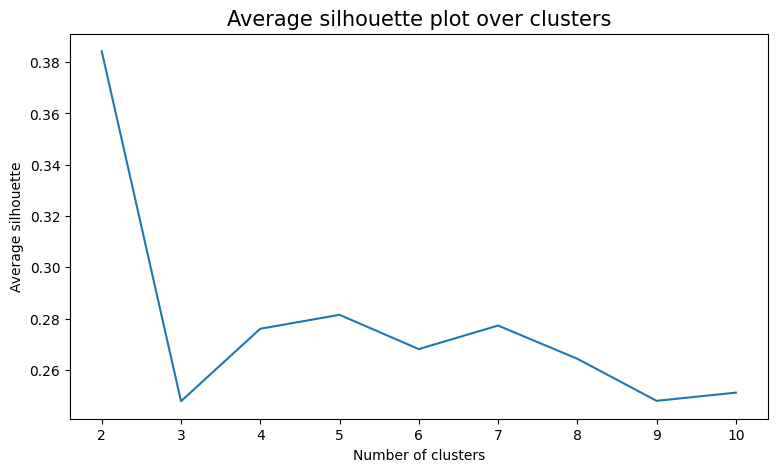

In [18]:
plt.figure(figsize=(9,5))

plt.plot(list(K), silhouettes)

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()